# Customer Churn Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Mobile Customer Departure**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [HPO Train](#HPO-Train)
1. [Invoke endpoint](#Invoke-endpoint)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Losing customers is costly for any business.  Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator.  Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-churn'


role = get_execution_role()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-349934754982


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

In [6]:
!wget http://dataminingconsultant.com/DKD2e_data_sets.zip
!unzip -o DKD2e_data_sets.zip

--2018-09-25 06:15:02--  http://dataminingconsultant.com/DKD2e_data_sets.zip
Resolving dataminingconsultant.com (dataminingconsultant.com)... 160.153.91.162
Connecting to dataminingconsultant.com (dataminingconsultant.com)|160.153.91.162|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003616 (980K) [application/zip]
Saving to: ‘DKD2e_data_sets.zip’

DKD2e_data_sets.zip 100%[===================>] 980.09K  2.97MB/s    in 0.3s    

2018-09-25 06:15:03 (2.97 MB/s) - ‘DKD2e_data_sets.zip’ saved [1003616/1003616]

Archive:  DKD2e_data_sets.zip
 extracting: Data sets/adult.zip     
  inflating: Data sets/cars.txt      
  inflating: Data sets/cars2.txt     
  inflating: Data sets/cereals.CSV   
  inflating: Data sets/churn.txt     
  inflating: Data sets/ClassifyRisk  
  inflating: Data sets/ClassifyRisk - Missing.txt  
 extracting: Data sets/DKD2e data sets.zip  
  inflating: Data sets/nn1.txt       


In [3]:
churn = pd.read_csv('./Data sets/churn.txt')
pd.set_option('display.max_columns', 500)
churn

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False.
6,MA,121,510,355-9993,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False.
7,MO,147,415,329-9001,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False.
8,LA,117,408,335-4719,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False.
9,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False.


By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

col_0,% observations
State,
AK,0.015602
AL,0.024002
AR,0.016502
AZ,0.019202
CA,0.010201
CO,0.019802
CT,0.022202
DC,0.016202
DE,0.018302


col_0,% observations
Phone,
327-1058,0.0003
327-1319,0.0003
327-3053,0.0003
327-3587,0.0003
327-3850,0.0003
327-3954,0.0003
327-4795,0.0003
327-5525,0.0003
327-5817,0.0003


col_0,% observations
Int'l Plan,
no,0.90309
yes,0.09691


col_0,% observations
VMail Plan,
no,0.723372
yes,0.276628


col_0,% observations
Churn?,
False.,0.855086
True.,0.144914


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


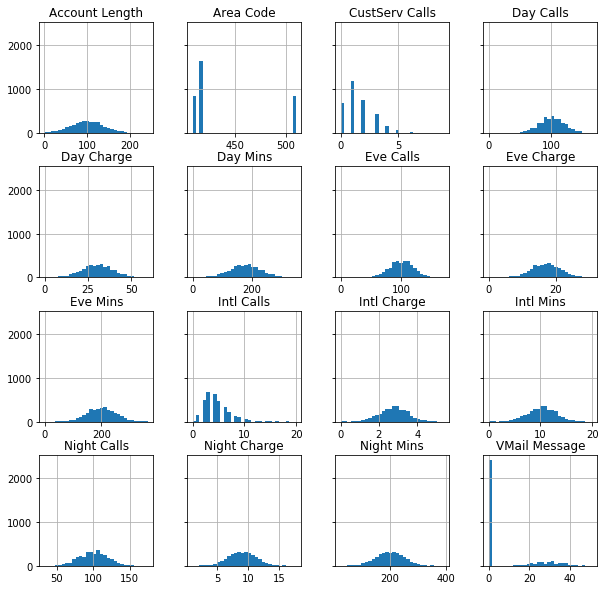

In [4]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that:
- `State` appears to be quite evenly distributed
- `Phone` takes on too many unique values to be of any practical use.  It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
- Only 14% of customers churned, so there is some class imabalance, but nothing extreme.
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity.  `VMail Message` being a notable exception (and `Area Code` showing up as a feature we should convert to non-numeric).

In [5]:
churn = churn.drop('Phone', axis=1)
churn['Area Code'] = churn['Area Code'].astype(object)

Next let's look at the relationship between each of the features and our target variable.

Churn?,False.,True.
State,,
AK,0.017193,0.006211
AL,0.025263,0.016563
AR,0.015439,0.022774
AZ,0.021053,0.008282
CA,0.008772,0.018634
CO,0.020000,0.018634
CT,0.021754,0.024845
DC,0.017193,0.010352
DE,0.018246,0.018634


Churn?,False.,True.
Area Code,,
408,0.251228,0.252588
415,0.497895,0.488613
510,0.250877,0.258799


Churn?,False.,True.
Int'l Plan,,
no,0.934737,0.716356
yes,0.065263,0.283644


Churn?,False.,True.
VMail Plan,,
no,0.704561,0.834369
yes,0.295439,0.165631


Account Length


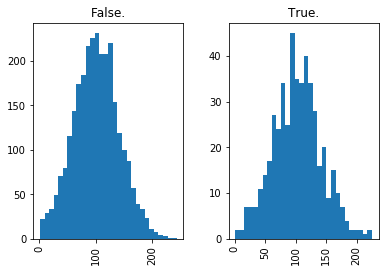

VMail Message


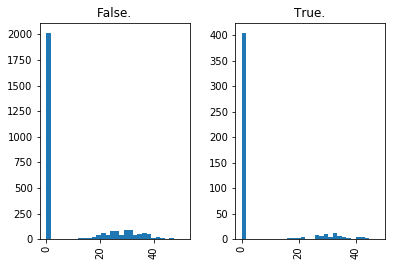

Day Mins


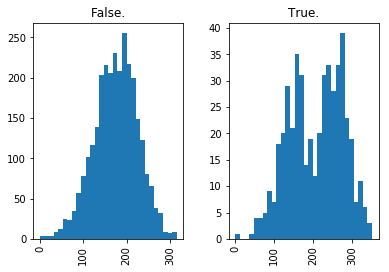

Day Calls


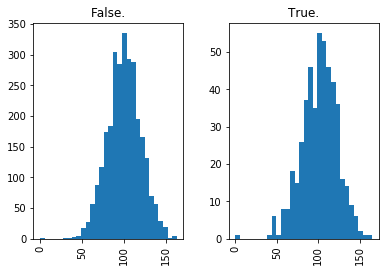

Day Charge


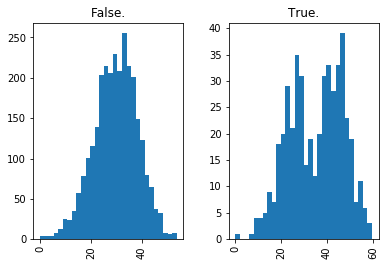

Eve Mins


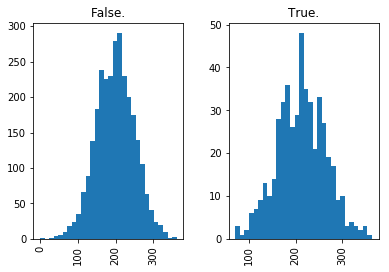

Eve Calls


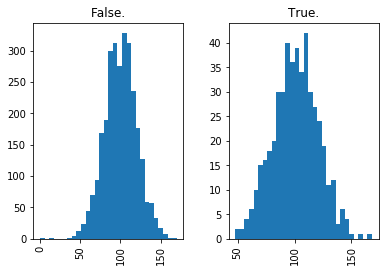

Eve Charge


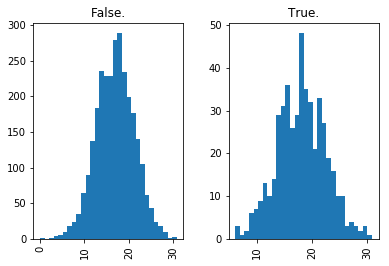

Night Mins


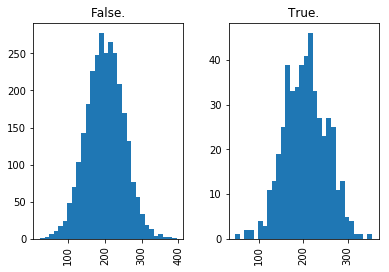

Night Calls


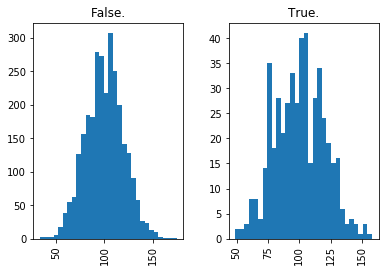

Night Charge


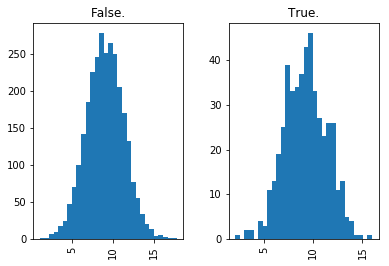

Intl Mins


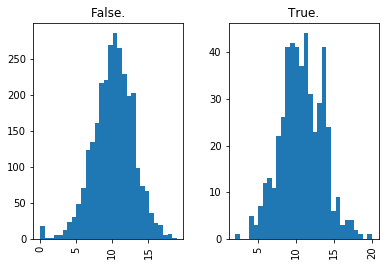

Intl Calls


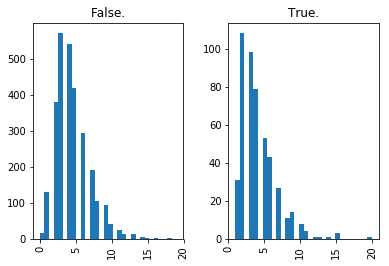

Intl Charge


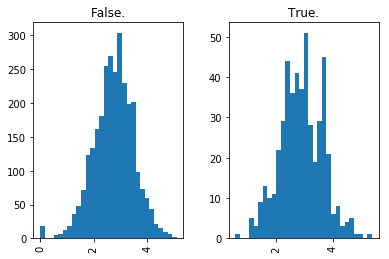

CustServ Calls


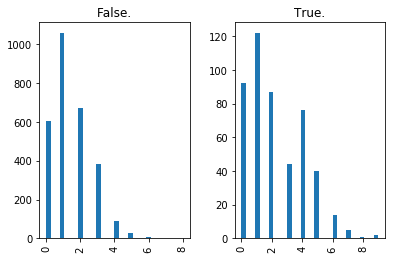

In [6]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=churn[column], columns=churn['Churn?'], normalize='columns'))

for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Churn?']].hist(by='Churn?', bins=30)
    plt.show()

Interestingly we see that churners appear:
- Fairly evenly distributed geographically
- More likely to have an international plan
- Less likely to have a voicemail plan
- To exhibit some bimodality in daily minutes (either higher or lower than the average for non-churners)
- To have a larger number of customer service calls (which makes sense as we'd expect customers who experience lots of problems may be more likely to churn)

In addition, we see that churners take on very similar distributions for features like `Day Mins` and `Day Charge`.  That's not surprising as we'd expect minutes spent talking to correlate with charges.  Let's dig deeper into the relationships between our features.

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
VMail Message,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Day Mins,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Day Calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Day Charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Eve Mins,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
Eve Calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
Eve Charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
Night Mins,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288
Night Calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802


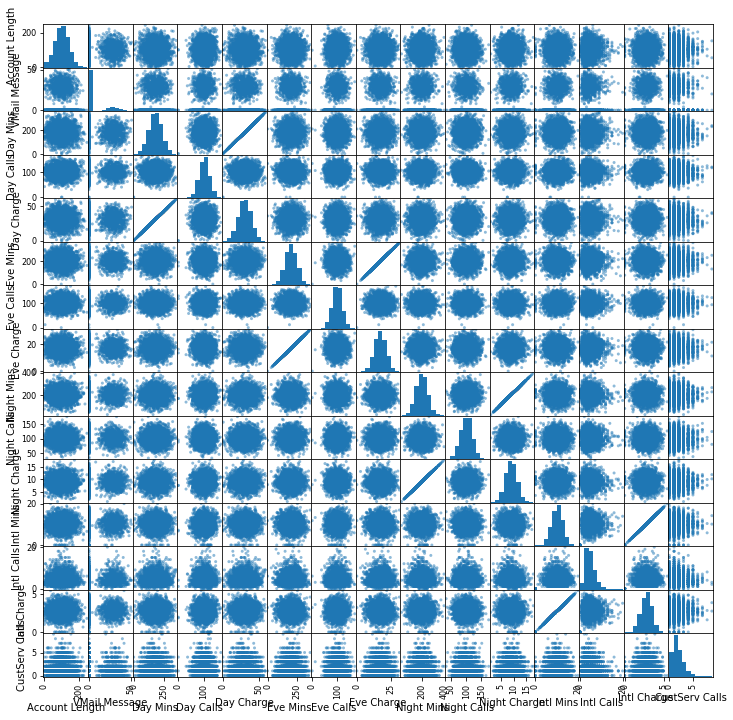

In [7]:
display(churn.corr())
pd.plotting.scatter_matrix(churn, figsize=(12, 12))
plt.show()

We see several features that essentially have 100% correlation with one another.  Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias.  Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

In [8]:
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

Now that we've cleaned up our dataset, let's determine which algorithm to use.  As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn.  In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms.  Instead, let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

But first, let's convert our categorical features into numeric features.

In [9]:
model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [14]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [15]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## HPO Train

Moving onto training by using Hyper-parameter optimization, first we'll need to specify the locations of the XGBoost algorithm containers.

In [14]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(boto3.Session().region_name, 'xgboost')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [22]:
s3_input_train = 's3://{}/{}/train'.format(bucket, prefix)
s3_input_validation ='s3://{}/{}/validation/'.format(bucket, prefix)

In [19]:
print(s3_input_train)

s3://sagemaker-us-east-1-349934754982/sagemaker/DEMO-xgboost-churn/train


Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

We will provide ranges of interest to for the algorithm to search the optimal configuration.

More detail on XGBoost's hyperparmeters can be found on the Sagemaker docs [page](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html).

In [92]:
from time import gmtime, strftime, sleep
tuning_job_name = 'xgboost-tuningjob-' + strftime("%d-%H-%M-%S", gmtime())

print (tuning_job_name)

tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta",
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight",
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha",            
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth",
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 40,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:auc",
      "Type": "Maximize"
    }
  }


xgboost-tuningjob-25-16-41-08


We configure our training job (data input for training and validation, instances to be used for running the jobs, etc.)

In [61]:
from sagemaker.amazon.amazon_estimator import get_image_uri

    
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": training_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix)
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "auc",
      "num_round": "100",
      "objective": "binary:logistic",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}



In [62]:
region = boto3.Session().region_name    
client = boto3.Session().client('sagemaker')

client.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                            HyperParameterTuningJobConfig = tuning_job_config,
                                            TrainingJobDefinition = training_job_definition)



{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:349934754982:hyper-parameter-tuning-job/xgboost-tuningjob-25-11-33-36',
 'ResponseMetadata': {'RequestId': 'e2efe3df-8636-4610-bc18-055fd0903ef6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e2efe3df-8636-4610-bc18-055fd0903ef6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Tue, 25 Sep 2018 11:35:14 GMT'},
  'RetryAttempts': 0}}

In [26]:
client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobStatus']

'InProgress'

---
## Invoke endpoint

Now that we've trained the algorithm and created the endpoint let's invoke the model and deploy for inference.

In [63]:
xgb_predictor = sagemaker.predictor.RealTimePredictor('XGboost-churn-best2-endpoint')

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [64]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [66]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the customer churned (`1`) or not (`0`), which produces a simple confusion matrix.

In [68]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,282,3
1,11,37


_Note, due to randomized elements of the algorithm, you results may differ slightly._

Of the 48 churners, we've correctly predicted 39 of them (true positives). And, we incorrectly predicted 4 customers would churn who then ended up not doing so (false positives).  There are also 9 customers who ended up churning, that we predicted would not (false negatives).

An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1 and we force them into the binary classes that we began with.  However, because a customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider adjusting this cutoff.  That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

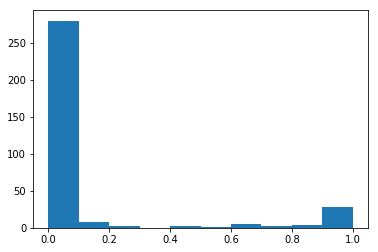

In [69]:
plt.hist(predictions)
plt.show()

The continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9 that adjusting the cutoff should indeed shift a number of customers' predictions.  For example...

In [71]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.2, 1, 0))

col_0,0,1
0,,
0,280,5
1,8,40


We seem to have found an optimal cutoff for our model. We can now use this to determine the users who are high risk of churn and need to be targeted.

In [91]:
target_clients=np.where(predictions>.2)
print('Following clients have been determined as high risk of churn and should be engaged: ',target_clients[0])

Following clients have been determined as high risk of churn and should be engaged:  [  5  20  26  34  44  53  56  74  84  95  97 104 117 126 127 136 142 153
 157 160 173 174 182 184 193 196 208 209 219 226 227 234 235 239 267 270
 271 284 286 292 302 316 317 324 327]


In [85]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_recall_fscore_support

In [78]:
def f1(y, t):
    t = t.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y]   # change the prob to class output
    return 'f1', f1_score(t, y_bin)

def print_evaluation_metric (y_true, y_pred):
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred)
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F-score: {}".format(fscore))
    print("Support: {}".format(support))
    return 



def plot_roc_curve (y_true, y_prob):
    fpr, tpr, threshold = roc_curve(y_true, y_prob)
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.plot(fpr, tpr, 'b')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return

In [79]:
print_evaluation_metric (test_data.iloc[:, 0], np.where(predictions > 0.5, 1, 0))

Precision: [0.96245734 0.925     ]
Recall: [0.98947368 0.77083333]
F-score: [0.97577855 0.84090909]
Support: [285  48]


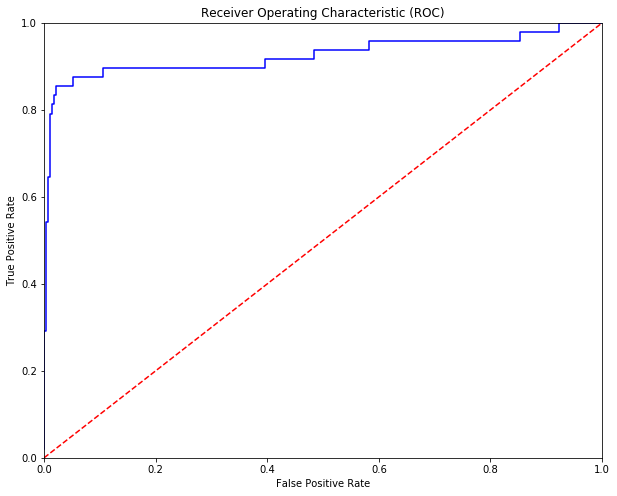

In [80]:
plot_roc_curve(test_data.iloc[:, 0], predictions)

We can see that changing the cutoff from 0.5 to 0.3 results in 1 more true positives, 3 more false positives, and 1 fewer false negatives.  The numbers are small overall here, but that's 6-10% of customers overall that are shifting because of a change to the cutoff.  Was this the right decision?  We may end up retaining 3 extra customers, but we also unnecessarily incentivized 5 more customers who would have stayed.  Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting.  Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)